In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import h5py
import numpy.ma as ma
from scipy.signal import butter, lfilter, freqz
from scipy.interpolate import interp1d

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#Opening h5 data file, reading data into arrays, then closing file
file_name = '20120123.004_lp_5min-cal.h5'
hf = h5py.File(file_name, 'r')

altitude = np.array(hf['NeFromPower/Altitude'])
Ne_NoTr = np.array(hf['NeFromPower/Ne_NoTr'])
dtime = np.array(hf['Time/dtime'])

hf.close()

#Printing shape of arrays
print altitude.shape
print Ne_NoTr.shape
print dtime.shape

(4, 180)
(159, 4, 180)
(159, 2)


In [4]:
Ne_alt_0_p_0 = Ne_NoTr[:,0,0] # 1-D Ne array for altitude 0 and pole 0
Ne_alt_0_p_0_m1 = ma.masked_less_equal(Ne_alt_0_p_0,0) # masking negative electron densities
Ne_alt_0_p_0_m2 = np.ma.masked_invalid(Ne_alt_0_p_0_m1) # masking NaN values
dtime_shift = np.copy(dtime)
dtime_shift[111,1] += 24
dtime_shift[112:,:]+= 24
dtime_shift_mean = np.mean(dtime_shift,axis=1)

In [5]:
Ne_index = ma.nonzero(Ne_alt_0_p_0_m2)
time_mask_removed = np.copy(dtime_shift_mean)
for i in range(159):
    if np.isin(i,Ne_index) == False:
      time_mask_removed[i] = 0

In [6]:
time_interp = time_mask_removed[np.nonzero(time_mask_removed)]

In [7]:
Ne_interp = ma.compressed(Ne_alt_0_p_0_m2)

In [8]:
print len(time_interp), len(Ne_interp)

112 112


In [9]:
interp_fun_alt = interp1d(time_interp, Ne_interp,kind='cubic')

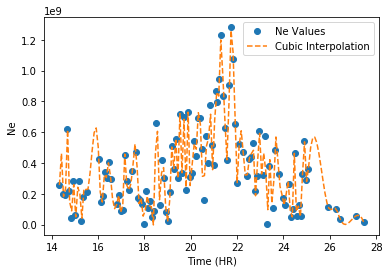

In [18]:
N = Ne_index[0]
n_time_elements = int(N[-1]) - int(N[0])+1
time_array = np.linspace(time_interp[0],time_interp[-1],n_time_elements)
plt.plot(dtime_shift_mean,Ne_alt_0_p_0_m2,'o', label = 'Ne Values')
plt.plot(time_array,interp_fun_alt(time_array),'--', label = 'Cubic Interpolation')
plt.legend(loc = 'upper right')
plt.xlabel('Time (HR)')
plt.ylabel('Ne')
plt.savefig('Interp_Ne_vs_Time.png')

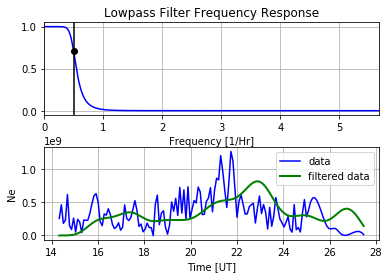

In [26]:
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs                    #Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
sampling_period_hr = time_array[1] - time_array[0]
fs = float(1) / float(sampling_period_hr) # sampling frequency, Hz
cutoff = float(1) / float(2) # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, 8000)
im = plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [1/Hr]')
plt.grid()

t = time_array
data = interp_fun_alt(time_array)
#Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [UT]')
plt.ylabel('Ne')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.savefig('B_Lowpass_Ne_vs_Time.png')